### Reseach Question: What factors influence the length of treatment after an individual has a concussion? <br>
<br>
Currently, demographic factors, clinical history, and social determinants of health are included. Results from the concussion evaluation (i.e. ImPACT results are not included). <br>
<br>
Approach: all-group Kaplan-Meier survival curve/analysis, and Cox Proportional Hazards for individual covariate assessment

TODO: add in SVI data (awaiting zipcodes for patient_ids

In [80]:
#load libraries
library(survival)
install.packages("ranger", repos='http://cran.us.r-project.org') #if not installed
library(ranger) #for random forest, may be obsolete
library(dplyr)
library(ggplot2)
install.packages("ggfortify", repos='http://cran.us.r-project.org') #if not installed
library(ggfortify)
install.packages("sqldf", repos='http://cran.us.r-project.org')
library(sqldf)


Warning message:
"package 'ranger' is in use and will not be installed"Warning message:
"package 'ggfortify' is in use and will not be installed"Warning message:
"package 'sqldf' is in use and will not be installed"

<br>
Data for this analysis includes all individuals with a diagnosed concussion between the dates of X and X (TODO) and were seen at the KUMC Concussion Clinic. <br>
<br>
Variables assessed: <br>
- Age<br>
- Sex<br>
- Race <br>
- English speaking <br>
- Relgious <br>
- Social determinants of health <br>
- Previous concussion diagnosis <br>
- Diagnosed ADHD, migraines, anxiety, learning, and other psychiatric disorders <br>


In [7]:
#load data:
setwd("C:/Users/MB047320/OneDrive - Cerner Corporation/KUMC/Dissertation/data/Mark_dissertation_20170718/")
surv <- read.csv("survival_analysis_df.csv")
head(surv)

X,patient_num,length_of_treat,sex,english_speaking,religious,age,race,ADHD,Anxiety,Concussion,Depression,Dyslexia,Migraine,Psychiatric_illness,dc
1,1000531,7,m,1,1,18,white,0,0,0,0,0,0,0,1
2,1005576,0,m,1,1,22,white,0,0,0,0,0,0,0,1
3,1008021,0,m,1,0,26,white,0,0,0,0,0,0,0,1
4,1012467,0,m,1,1,18,white,0,0,1,0,0,0,0,1
5,1013758,5,m,1,1,17,white,0,0,0,0,0,0,0,1
6,1013820,8,m,1,0,20,white,0,0,1,0,0,0,0,1


The dataset contains 665 individuals seen at the KUMC Concussion clinic and had a diagnosed concussion. Some variables were converted to binary categories, like 'english-speaking' and 'religious'. A '1' for these variables represents a positive event (i.e. 1 = patient speaks English, or is religious). <br>
<br>


## Kaplan Meier Survival Analysis
Survival analysis has traditionally been used to describe interventional approaches and the impact on survival (i.e. Death over time). The analysis is of interest to me, as I am interested in determining the time till an event of interest (length of treatment, or time to discharge). 

In [11]:
#surv() to build survival object
km <- with(surv, Surv(length_of_treat, dc))

Build Kaplan Meier 'survival' probability estimates of survival over time

In [14]:
km_fit <- survfit(Surv(length_of_treat,dc)~1, data = surv)
summary(km_fit, times = c(1,5,10,15,20*(1:10))) #prints estimates for 1,5,10 etc, days, then every 20 days after

Call: survfit(formula = Surv(length_of_treat, dc) ~ 1, data = surv)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1    439     226  0.66015 0.01837      0.62511       0.6972
    5    435      13  0.64060 0.01861      0.60515       0.6781
   10    295     146  0.42105 0.01915      0.38515       0.4603
   15    222      63  0.32632 0.01818      0.29256       0.3640
   20    193      29  0.28271 0.01746      0.25047       0.3191
   40     99      92  0.14436 0.01363      0.11997       0.1737
   60     59      37  0.08872 0.01103      0.06954       0.1132
   80     36      23  0.05414 0.00877      0.03940       0.0744
  100     22      14  0.03308 0.00694      0.02194       0.0499
  120     14       8  0.02105 0.00557      0.01254       0.0354
  140     12       2  0.01805 0.00516      0.01030       0.0316
  160      9       4  0.01203 0.00423      0.00604       0.0240
  180      6       2  0.00902 0.00367      0.00407       0.0200
  200      3       3  0.00451 0.002

Displayed above are the events and 'risk' estimates at different time points (1 day, 5 days etc). Here, the survival statistic is opposite of how the metric is traditionally interpretted. Because my analysis is evaluating a positive event (time to discharge), as opposed to mortality, we actually want this statistic to be smaller over time. Again, traditionally, this represents survival and we would want it as high over time, but in this case, a higher number represents a greater likelihood of continued treatment (and thus, lack of recovery).

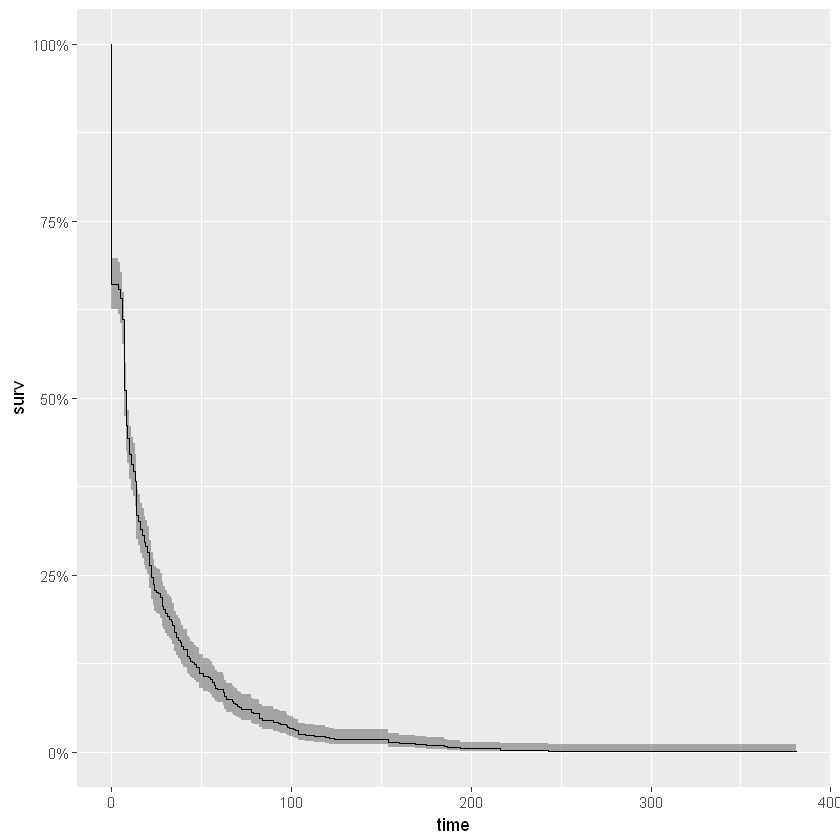

In [16]:
#plot general survival curve (time = days)
autoplot(km_fit)

In survival plot, you'll notice a large drop immediately. This represents ~35% of the population went to their evaluation appointment, but never followed up again and thus only had 1 clinic visit.<br>
<br>
The survival plot does show that generally, the population gets better quickly. Roughly 25% of the population has been discharged by day 25, which is in line with most literature.

Call: survfit(formula = Surv(length_of_treat, dc) ~ sex, data = surv)

        n events median 0.95LCL 0.95UCL
sex=f 276    276     10       8      14
sex=m 389    389      7       7       8


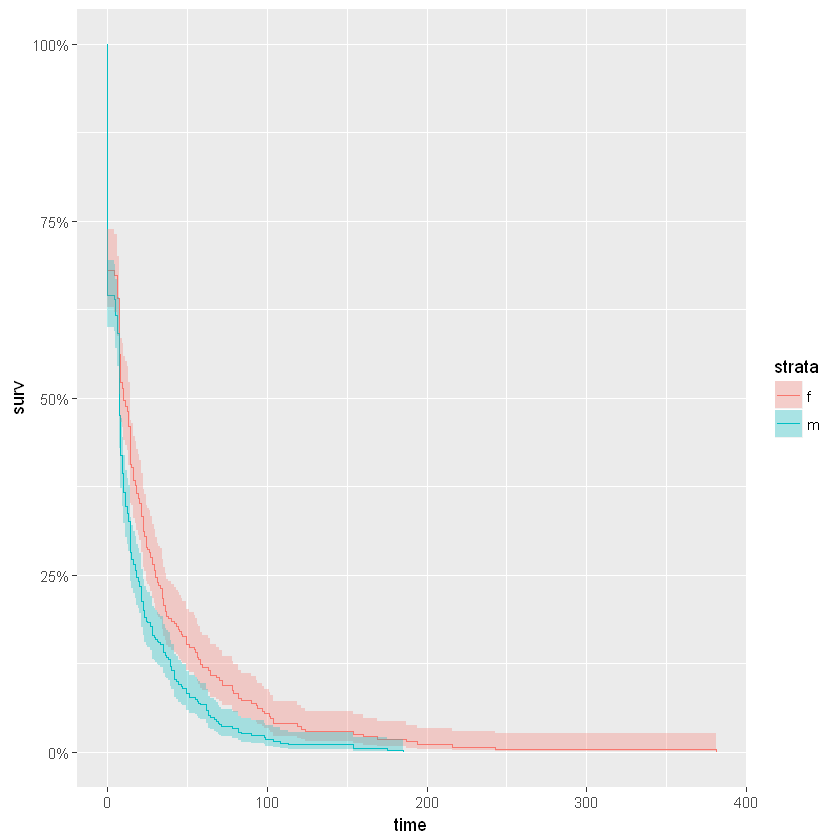

In [76]:
#plot survival curve by sex (aka strata)
km_sex_fit <- survfit(Surv(length_of_treat,dc)~ sex, data = surv) #need to refit with sex as a grouper
autoplot(km_sex_fit)
print(km_sex_fit)

Looks like there is a difference in treatment time between sexes... Not sure if the difference is significant (yet). To assess whether the difference between the two curves is statistically significant, I'll need to do a Log Rank test comparing the curves using the function (survdiff()).

In [83]:
surv_diff_sex <- survdiff(Surv(length_of_treat, dc) ~ sex, data = surv)
surv_diff_sex

Call:
survdiff(formula = Surv(length_of_treat, dc) ~ sex, data = surv)

        N Observed Expected (O-E)^2/E (O-E)^2/V
sex=f 276      276      320      5.98      14.1
sex=m 389      389      345      5.54      14.1

 Chisq= 14.1  on 1 degrees of freedom, p= 0.000174 

<br>
<br>
Interpretting the Log Rank test between the Male/Female survival plots: <br>
<br>
Much like a t-test, the log rank test's null hypothesis is that there are no differences between groups (and thus, survival curves). A p-value of less than 0.05 would indicate a significant difference (like a T-test). <br>
<br>p = 0.000174 < 0.05, indicating a statistically significant difference between the sexes.

 #### Plotting other possible groupers:

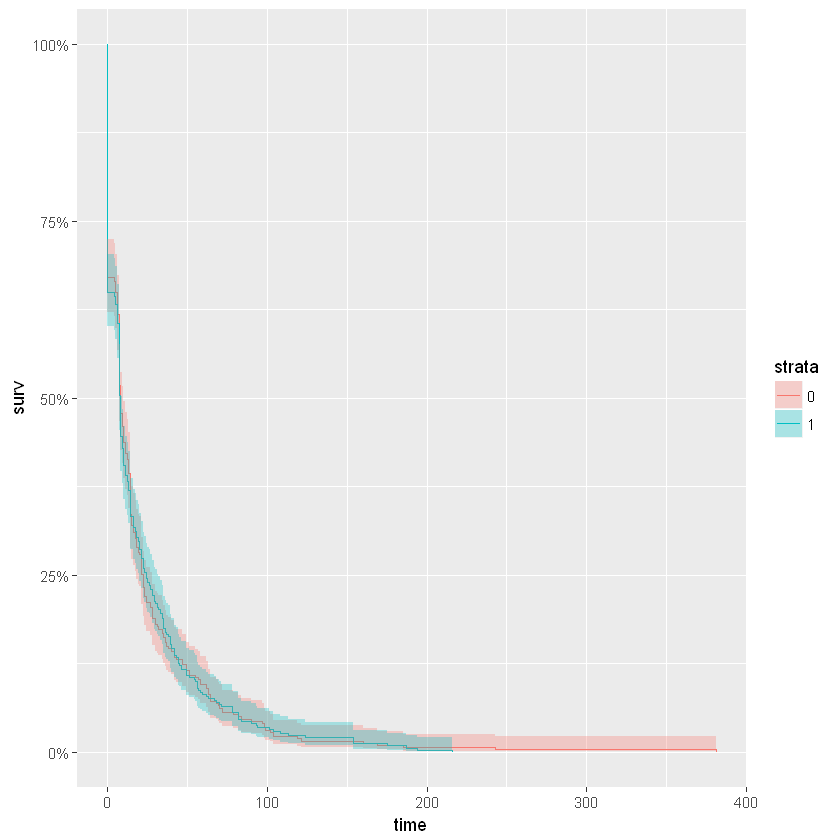

In [20]:
#plot survival curve by religious
km_religious_fit <- survfit(Surv(length_of_treat,dc)~ religious, data = surv) #need to refit with sex as a grouper
autoplot(km_religious_fit)

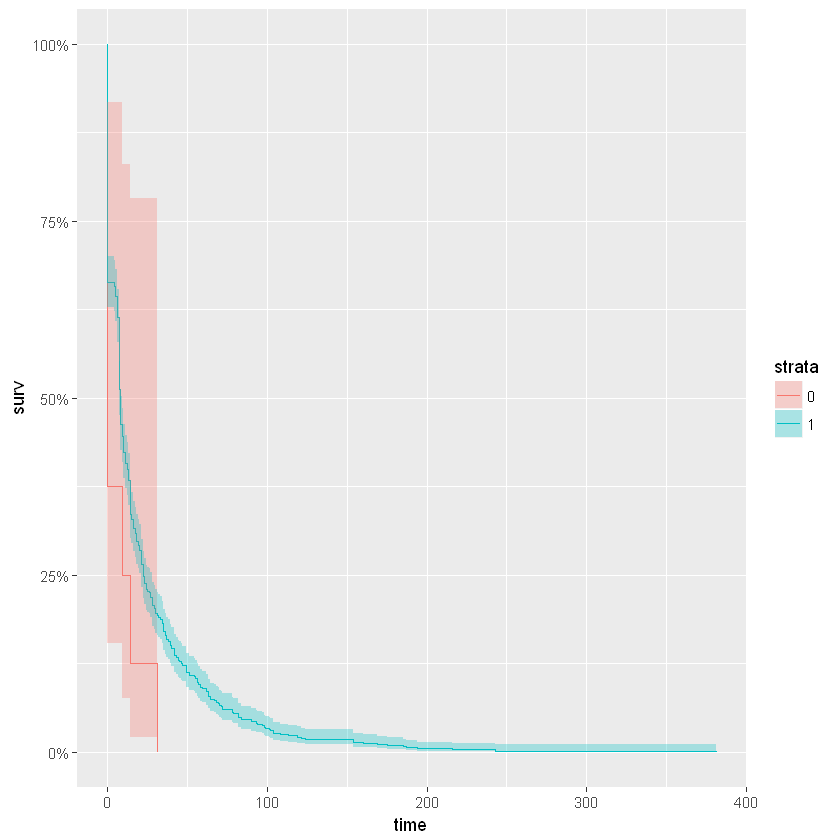

In [73]:
#plot survival curve by english speaking
km_eng_fit <- survfit(Surv(length_of_treat,dc)~ english_speaking, data = surv) 
autoplot(km_eng_fit)

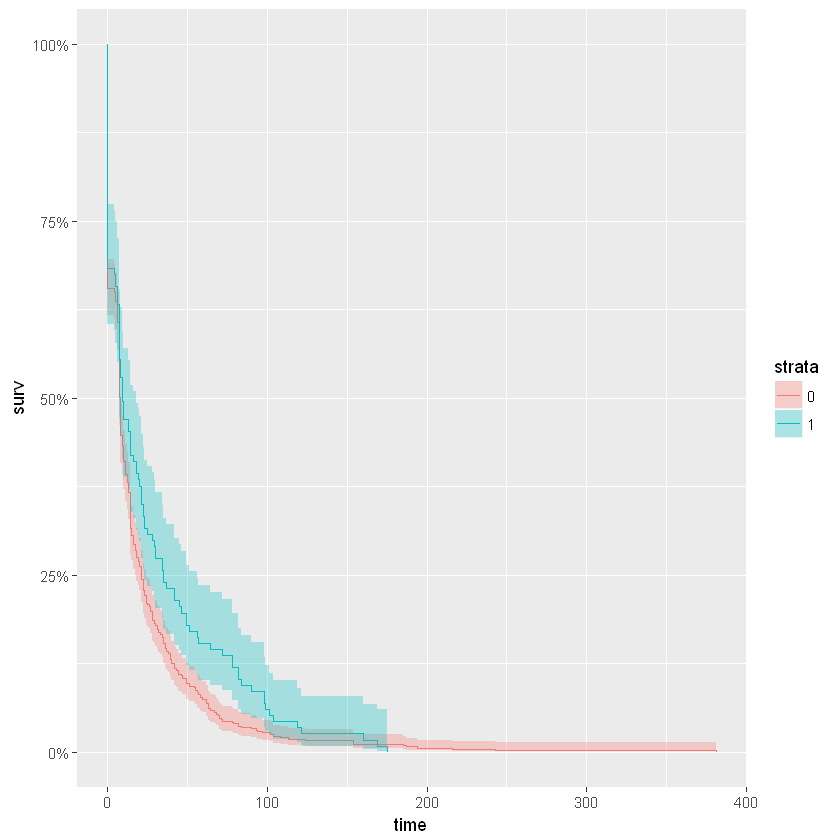

In [27]:
#plot survival curve by concussion history
km_concussion_fit <- survfit(Surv(length_of_treat,dc)~ Concussion, data = surv) 
autoplot(km_concussion_fit)

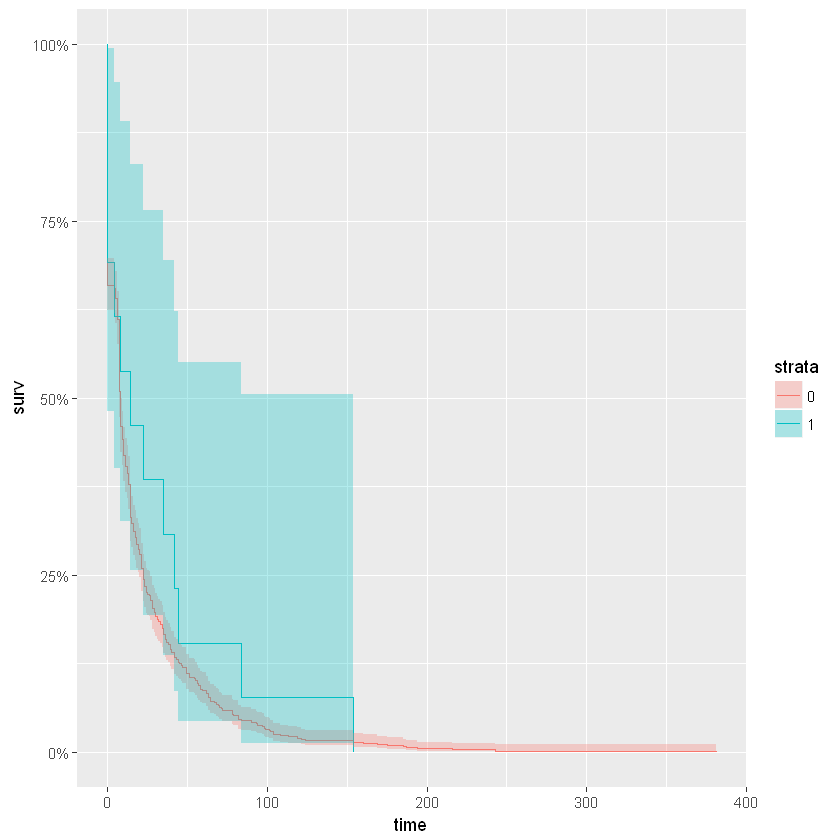

In [30]:
#plot survival curve by anxiety dx
km_anx_fit <- survfit(Surv(length_of_treat,dc)~ Anxiety, data = surv) 
autoplot(km_anx_fit)

In [38]:
#displaying counts of patients with each diagnosis
sqldf("select SUM(ADHD) as ADHD
,SUM(Anxiety) as Anxiety
,SUM(Concussion) as Concussion
,SUM(Depression) as Depression
,SUM(Dyslexia) as Dyslexia
,SUM(Migraine) as Migraine
,SUM(Psychiatric_illness) as Psychiatric_illness
from surv")

ADHD,Anxiety,Concussion,Depression,Dyslexia,Migraine,Psychiatric_illness
28,13,117,10,1,8,1


Note: there are not many people with other diagnoses of interest. Thus, individual comparisons should be considered cautiously. Concussion history may be meaningful, though. <br>
<br>
Age is a continuous variable and can't plot without dichotomizing. Since age is previously important for recovery, slicing the data at a specific range could be interesting.

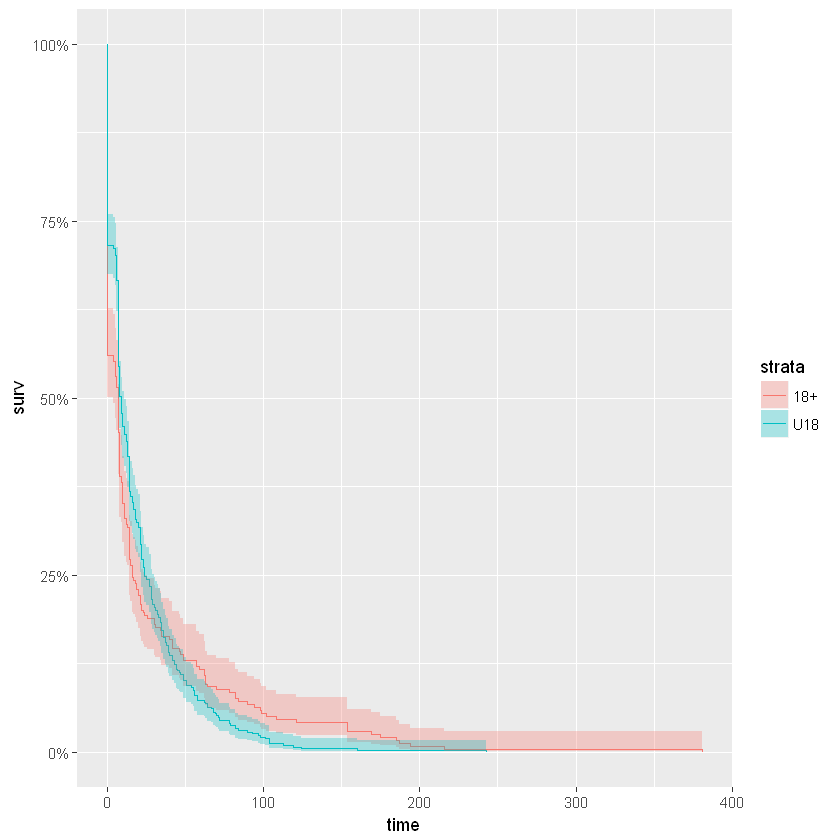

In [55]:
#create new dataframe with age separated into dummy (18yo)
age <- mutate(surv, AG = ifelse((age < 18), "U18", "18+"),
             AG = factor(AG))
km_AG_fit <- survfit(Surv(length_of_treat,dc) ~ AG, data = age)
autoplot(km_AG_fit)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9.00   15.00   17.00   17.55   18.00   65.00 

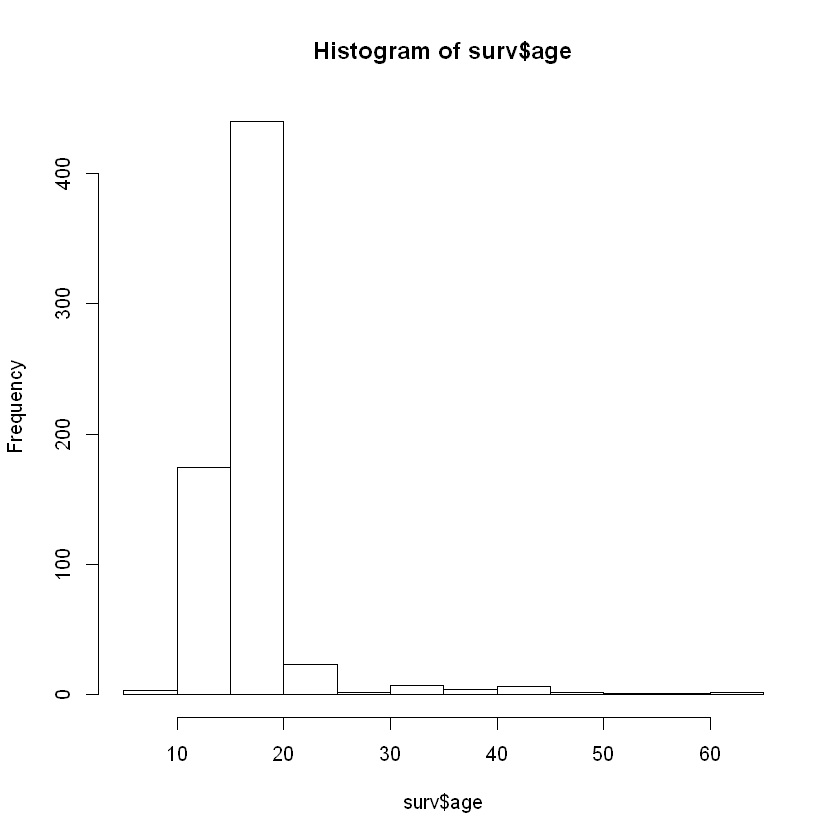

In [52]:
summary(surv$age)
hist(surv$age)

It looks like there could be an age effect, as older individuals appear to have longer tx.

## Cox Proportional Hazards regression

https://en.wikipedia.org/wiki/Proportional_hazards_model <br>
http://www.sthda.com/english/wiki/cox-proportional-hazards-model <br>

###### Univariate Cox regression

In [88]:
res.cox <- coxph(Surv(length_of_treat, dc) ~ sex, data = surv)
summary(res.cox)

Call:
coxph(formula = Surv(length_of_treat, dc) ~ sex, data = surv)

  n= 665, number of events= 665 

        coef exp(coef) se(coef)     z Pr(>|z|)    
sexm 0.29152   1.33846  0.07994 3.647 0.000266 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

     exp(coef) exp(-coef) lower .95 upper .95
sexm     1.338     0.7471     1.144     1.565

Concordance= 0.535  (se = 0.015 )
Rsquare= 0.02   (max possible= 1 )
Likelihood ratio test= 13.49  on 1 df,   p=0.0002404
Wald test            = 13.3  on 1 df,   p=0.0002655
Score (logrank) test = 13.39  on 1 df,   p=0.0002532


In the univariate run (as sex as a covariate), p < 0.05, thus significant model. Beta coefficient of 0.29152 indicates that females have a higher risk of long treatments, when compared to males. Hazard ratios give the effect size of the covariate. Here, being female increases the hazard by a factor of 1.34. Being male is associated with a better prognostic, which coincides with the literature. NOTE: Since my outcome of interest (Length of treatment time) represents the opposite interpretation as Survival, ideally all hazard ratios should be interpretted inversely. (here, a positive hazard ratio for male sex would indicate quicker death, but with LOT, it indicates a faster recovery)
<br>
<br>
###### Multivariate Cox regression <br>


In [89]:
cox <- coxph(Surv(length_of_treat, dc) ~ sex + english_speaking + religious + age + race + ADHD + Anxiety + Concussion +
             Depression + Dyslexia + Migraine + Psychiatric_illness, data = surv)
summary(cox)

Call:
coxph(formula = Surv(length_of_treat, dc) ~ sex + english_speaking + 
    religious + age + race + ADHD + Anxiety + Concussion + Depression + 
    Dyslexia + Migraine + Psychiatric_illness, data = surv)

  n= 665, number of events= 665 

                         coef exp(coef)  se(coef)      z Pr(>|z|)    
sexm                 0.307632  1.360200  0.082363  3.735 0.000188 ***
english_speaking    -0.698758  0.497202  0.364386 -1.918 0.055157 .  
religious           -0.026716  0.973638  0.079972 -0.334 0.738333    
age                 -0.017415  0.982736  0.007295 -2.387 0.016971 *  
raceasian            0.354748  1.425821  1.070051  0.332 0.740249    
raceblack           -0.474382  0.622270  1.013832 -0.468 0.639849    
racedeclined        -0.500723  0.606092  1.073543 -0.466 0.640914    
raceother           -0.473139  0.623044  1.009123 -0.469 0.639169    
racepac islander     1.188334  3.281609  1.415695  0.839 0.401245    
racetwo races       -0.133210  0.875281  1.053215 -0.126

Interpretation: general model significance was reached, as all p-values for Likelihood ratio, Wald, and score tests are < 0.05. These tests basically test the null hypothesis that all covariate beta values are 0, so there is something going on here. <br>
<br>
Here, the covariates sex and age remain significant, with english_speaking, concussion history, and psychiatric illness representing covariates close to signficance. <br>
<br>
P-value for sex = 0.000188, with a hazards ratio of 1.36, indicating a strong relationship between the patient's sex and length of treatment time. Hazards ratios of covariates are interpretable as multiplicative effects on the hazard itself. For example, holding the other covariates constant, being female (sex = 'f') increases the hazard by a factor of 1.36, and is associated with longer recoveries.<br>
<br>
Similarly, the p-value for age was 0.01, but with a hazard ratio of .98, the continuous variable doesn't provide much change of risk across the age continuum in our participants (HR = 1 represents no change in risk). 

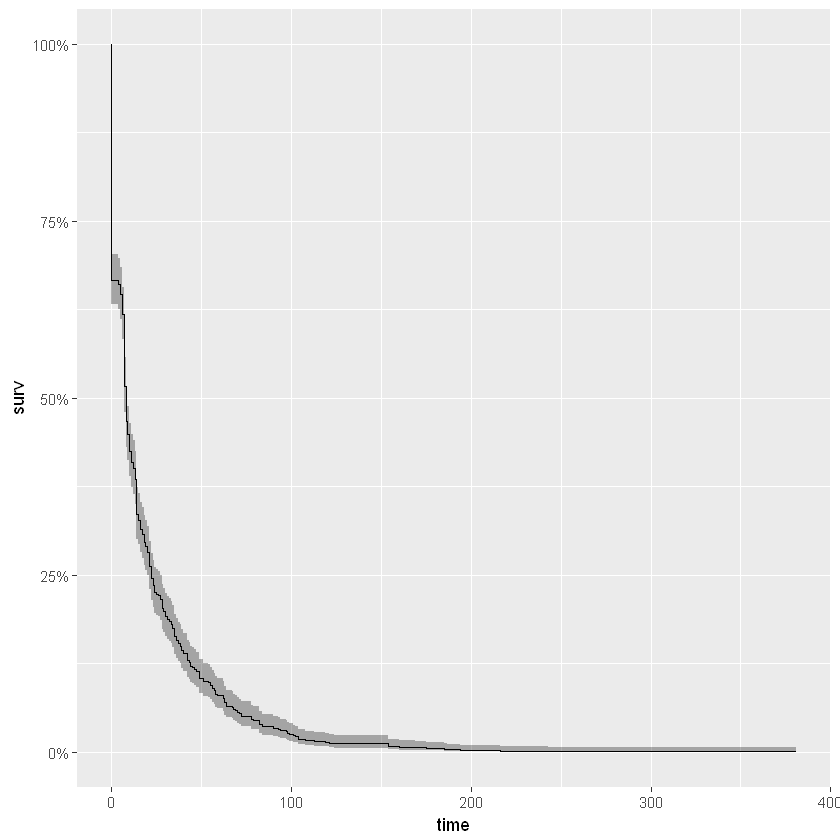

In [60]:
cox_fit <- survfit(cox)
autoplot(cox_fit)

Concordance stat is terrible, barely over a coinflip. Some of this may be improved with eliminating some dx categories (i.e. psych illness, which had one case, along with dyslexia).<br>
<br>
Cox regression has flagged age and sex as being statistically significant predictors, and a previous diagnosis of concussion and english-speaking as close covariates for inclusion.


### Random Forest model (for fun...)

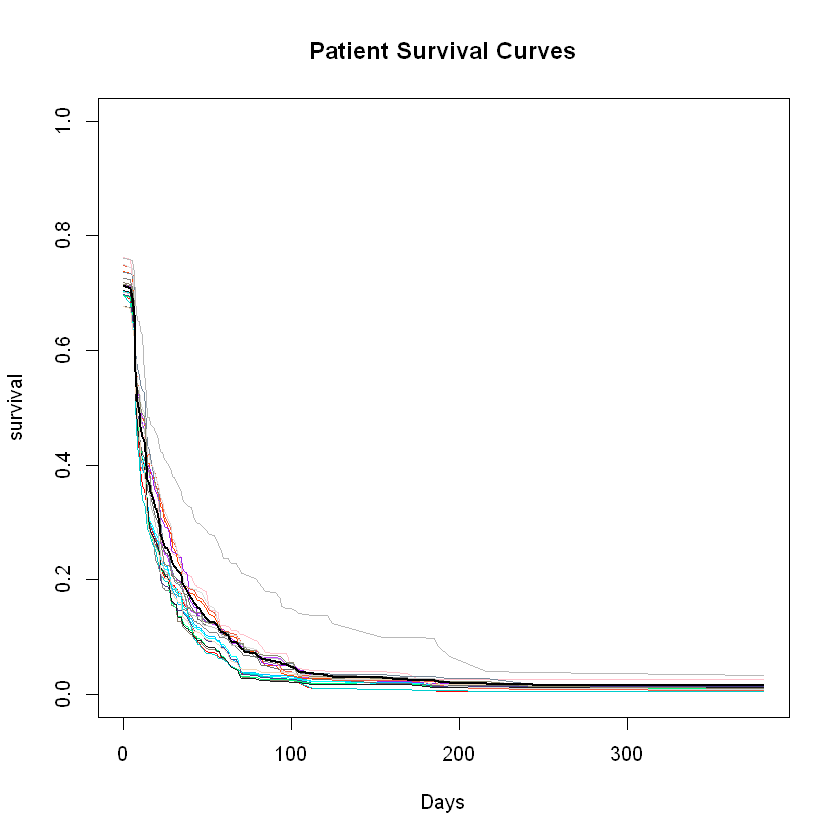

In [63]:
# ranger model
r_fit <- ranger(Surv(length_of_treat, dc) ~ sex + english_speaking + religious + age + race + ADHD + Anxiety + Concussion +
             Depression + Dyslexia + Migraine + Psychiatric_illness, data = surv,
                     mtry = 4,
                     importance = "permutation",
                     splitrule = "extratrees",
                     verbose = TRUE)

# Average the survival models
death_times <- r_fit$unique.death.times 
surv_prob <- data.frame(r_fit$survival)
avg_prob <- sapply(surv_prob,mean)

# Plot the survival models for each patient
plot(r_fit$unique.death.times,r_fit$survival[1,], 
     type = "l", 
     ylim = c(0,1),
     col = "red",
     xlab = "Days",
     ylab = "survival",
     main = "Patient Survival Curves")

#
cols <- colors()
for (n in sample(c(2:dim(surv)[1]), 20)){
  lines(r_fit$unique.death.times, r_fit$survival[n,], type = "l", col = cols[n])
}
lines(death_times, avg_prob, lwd = 2)
legend(500, 0.7, legend = c('Average = black'))

In [67]:
#Ranger rank of variable importance
vi <- data.frame(sort(round(r_fit$variable.importance, 10), decreasing = TRUE))
names(vi) <- "importance"
head(vi, 10)

,importance
sex,0.0191739064
Concussion,0.0069182495
Migraine,0.0000401710
Depression,0.0000141357
Dyslexia,0.0000000000
Psychiatric_illness,0.0000000000
Anxiety,-0.0000051948
ADHD,-0.0001460977
age,-0.0004083838
english_speaking,-0.0010083661


In [69]:
cat("Prediction Error = 1 - Harrell's c-index = ", r_fit$prediction.error)

Prediction Error = 1 - Harrell's c-index =  0.4774016

Random forest seems to be performing similarly to the Cox regression model. Concordance was 55%, this is about 53%.

In [70]:
# Set up for ggplot
kmi <- rep("KM",length(km_fit$time))
km_df <- data.frame(km_fit$time,km_fit$surv,kmi)
names(km_df) <- c("Time","Surv","Model")

coxi <- rep("Cox",length(cox_fit$time))
cox_df <- data.frame(cox_fit$time,cox_fit$surv,coxi)
names(cox_df) <- c("Time","Surv","Model")

rfi <- rep("RF",length(r_fit$unique.death.times))
rf_df <- data.frame(r_fit$unique.death.times,avg_prob,rfi)
names(rf_df) <- c("Time","Surv","Model")

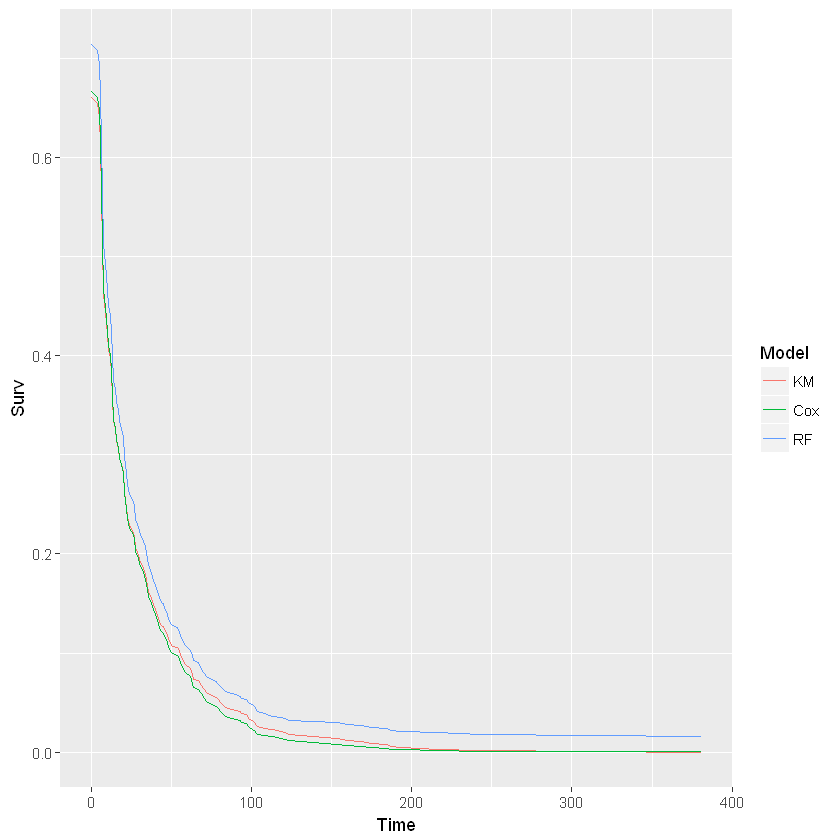

In [72]:
plot_df <- rbind(km_df, cox_df, rf_df)

p <- ggplot(plot_df, aes(x = Time, y = Surv, color = Model))
p + geom_line()

Given data, all three methods perform similarly. Granted 650 cases isn't likely enought data for a random forest model, it is still interesting to see the results. Although the random forest found different variables as most important.